# Predicting BMI from Face Image

##### Importing all required libraries

In [162]:
import numpy as np
import cv2
import random
import PIL.Image as Image
import os
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
pd.set_option('display.max_colwidth', None)

##### Downloading data from google cloud storage to local instance

In [2]:
# from google.cloud import storage

# # Authenticate with Google Cloud
# client = storage.Client()

# # Download all the files in the directory within the bucket
# bucket = client.get_bucket('ml-project-sarmad-afzal')
# blobs = bucket.list_blobs(prefix='Data/Images/')

# for blob in blobs:
#     # Download the file to the local file system
#     filename = blob.name.split('/Images/')[-1]
#     blob.download_to_filename(filename)


##### Viewing random pictures 

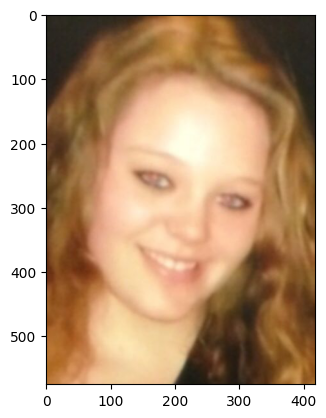

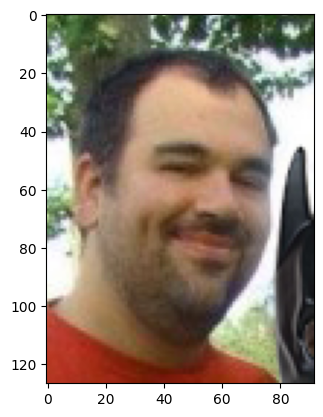

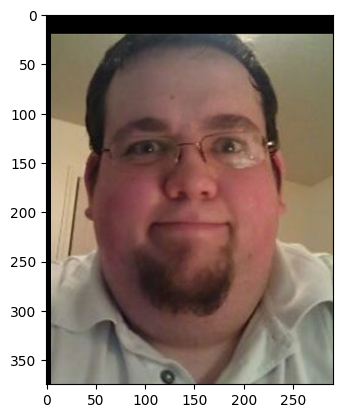

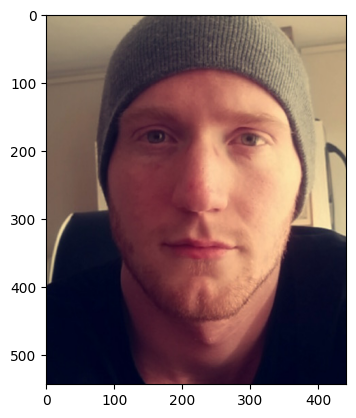

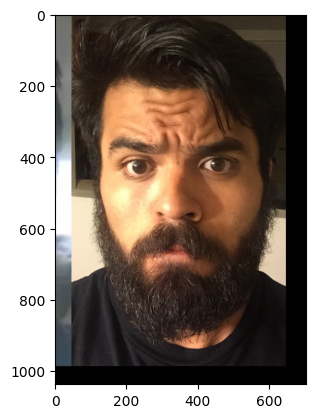

In [111]:
# get a list of all image files in the folder
image_files = os.listdir()

# display the first 5 images
for i in range(5):
    img = mpimg.imread(image_files[i])
    plt.imshow(img)
    plt.show()

##### Creating a list of all images which are in the folder

In [4]:
image_files = os.listdir()
image_files = list(image_files)

##### Checking names of files

In [112]:
image_files[:5]

['img_1592.bmp',
 'img_3047.bmp',
 'img_3174.bmp',
 'img_2973.bmp',
 'img_2401.bmp']

##### Reading dataframe which has all the lables

In [122]:
df = pd.read_csv('data_images.csv')

In [124]:
df = df.drop('Unnamed: 0', axis = 1)

In [125]:
df.head()

,bmi,name
0,34.207396,img_0.bmp
1,26.453720,img_1.bmp
2,34.967561,img_2.bmp
3,22.044766,img_3.bmp
4,37.758789,img_4.bmp


##### Some .bmp files are listed in the df but not available physically, so we will assign 1 to physical_status column if it is available physically as well so that we can later filter them

In [126]:
df['physical_status'] = np.where(df.name.isin(image_files), 1, 0)

In [127]:
df.head()

,bmi,name,physical_status
0,34.207396,img_0.bmp,1
1,26.453720,img_1.bmp,1
2,34.967561,img_2.bmp,1
3,22.044766,img_3.bmp,1
4,37.758789,img_4.bmp,0


##### Limiting df to only physically available images

In [128]:
df = df[df.physical_status == 1]

In [129]:
df.shape

(3962, 3)

##### Total we have around 4000 images to train our model which will not be enough to we will use **transfer learning** with VGG16 model

In [130]:
df = df.reset_index(drop = True)

In [131]:
df.head()

,bmi,name,physical_status
0,34.207396,img_0.bmp,1
1,26.453720,img_1.bmp,1
2,34.967561,img_2.bmp,1
3,22.044766,img_3.bmp,1
4,25.845588,img_6.bmp,1


##### Checking image shapes to have an idea of the dimension of our image data

In [132]:
rand_img = [random.randint(0,df.shape[0]-1) for i in range(10)]

In [133]:
for i in rand_img:
  img = cv2.imread(str(df.name.loc[i]))
  print(img.shape)

(418, 337, 3)
(191, 121, 3)
(404, 298, 3)
(92, 82, 3)
(88, 84, 3)
(245, 244, 3)
(182, 141, 3)
(504, 444, 3)
(436, 261, 3)
(360, 302, 3)


- There are random sizes, we will scale them to a common number (224 x 224)

In [134]:
X, y = [], []

for j in list(df.index):
  img = cv2.imread(str(df.name.loc[j]))
  resized_img = cv2.resize(img, (224, 224))
  X.append(resized_img)
  y.append(df.bmi.loc[j])

In [135]:
X = np.array(X)
y = np.array(y)

##### As we can see below all out images have same dimensions now

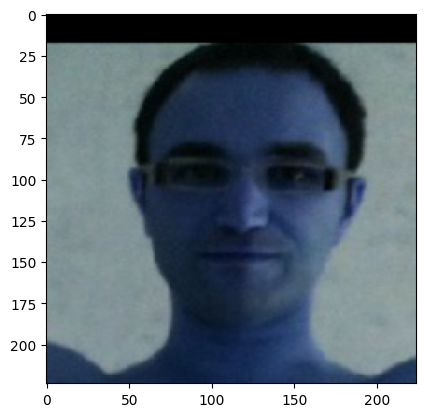

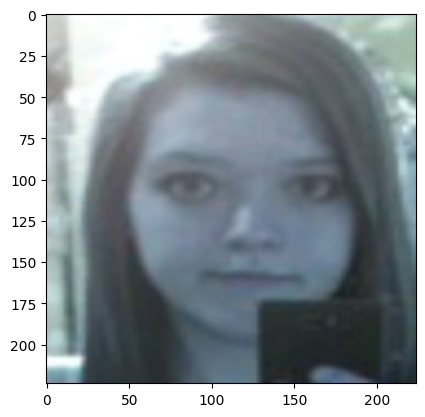

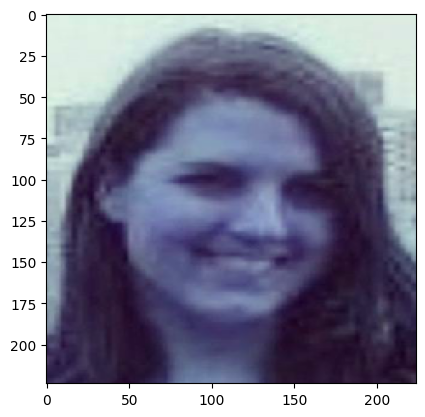

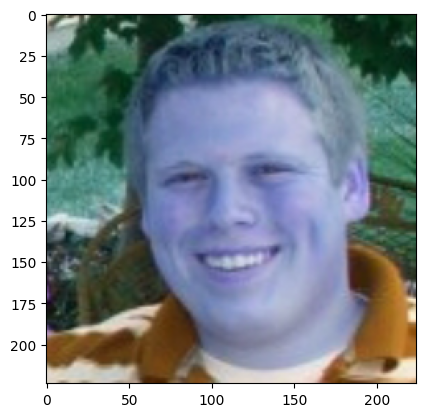

In [139]:
for i in [1,5,6,8]:
    plt.imshow(X[i])
    plt.show()

##### Checking somes labels data

In [140]:
y[0:10]

array([34.20739619, 26.45371972, 34.96756055, 22.04476644, 25.84558824,
       21.74070069, 30.61585799, 26.78887574, 38.73278237, 30.8248393 ])

##### Train test split
- Splitting data into train and test for validation in a ratio of 80:20

In [144]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size = 0.2)

##### Preprocessing data
- Normalization
- Data Augmentation

In [145]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [163]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [164]:
train_data_gen = datagen.flow(X_train_scaled, y_train, batch_size=32)

##### Loading Transfer learning model VGG16

In [166]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False ## Not trainable weights

##### Defining our model on top of base model which is VGG16
- Transfer Model
- Flatterning Layer
- Dense Layer with 100 neurons
- Dense Layer with 50 neurons
- Dense Layer with 20 neurons
- Prediction layer to predict BMI

In [181]:
layer_2d_1 = layers.Conv2D(filters=32, kernel_size=(2,2), activation='relu')
#layer_2d_2 = layers.MaxPooling2D(pool_size=(2,2))
layer_2d_3 = layers.Conv2D(filters=64, kernel_size=(2,2), activation='relu')
layer_2d_4 = layers.MaxPooling2D(pool_size=(2,2))
flatten_layer = layers.Flatten()
dense_layer_2 = layers.Dense(50, activation='relu')
dense_layer_3 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(1, activation='linear')

model = models.Sequential([
    base_model,
    layer_2d_1,
    #layer_2d_2,
    layer_2d_3,
    layer_2d_4,
    flatten_layer,
    dense_layer_2,
    dense_layer_3,
    prediction_layer
])


##### Model Compiler

In [183]:
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

##### Fitting the model

In [159]:
# save model
model.save('model.h5')
print("Saved model")

Saved model


In [184]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)


es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

model.fit(train_data_gen, epochs=5)


Epoch 1/5
100/100 [==============================] - 77s 757ms/step - loss: 177.5009 - root_mean_squared_error: 13.3229
Epoch 2/5
100/100 [==============================] - 76s 756ms/step - loss: 73.4529 - root_mean_squared_error: 8.5705
Epoch 3/5
100/100 [==============================] - 76s 757ms/step - loss: 70.1161 - root_mean_squared_error: 8.3735
Epoch 4/5
100/100 [==============================] - 76s 756ms/step - loss: 66.6623 - root_mean_squared_error: 8.1647
Epoch 5/5
100/100 [==============================] - 76s 753ms/step - loss: 64.7183 - root_mean_squared_error: 8.0448


In [188]:
df.bmi.describe()

count    3962.000000
mean       32.674278
std         8.272575
min        17.716216
25%        26.443866
50%        31.166739
75%        37.492724
max        85.987061
Name: bmi, dtype: float64

##### Evaluating Model

In [189]:
model.evaluate(X_test_scaled, y_test)

25/25 [==============================] - 18s 709ms/step - loss: 58.1552 - root_mean_squared_error: 7.6260


[58.155181884765625, 7.625954627990723]

##### Predicting on Test Data

In [196]:
pred = model.predict(X_test_scaled)

25/25 [==============================] - 18s 712ms/step


In [ ]:
import pandas as pd
import numpy as np 
import tensorflow as tf 


##### Comparing Results

Actual BMI: 33.199527745
Predicted BMI: 32.27981948852539


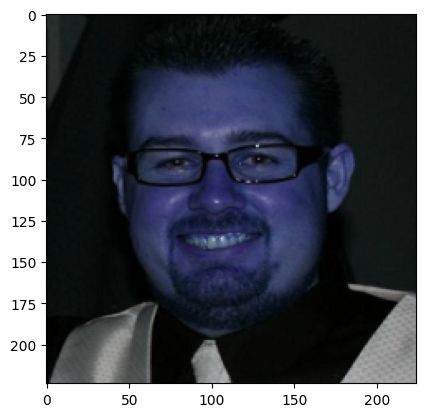

Actual BMI: 25.0568055246
Predicted BMI: 31.302959442138672


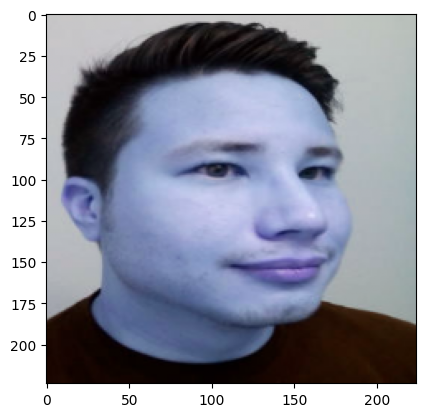

Actual BMI: 29.7837837838
Predicted BMI: 33.14202880859375


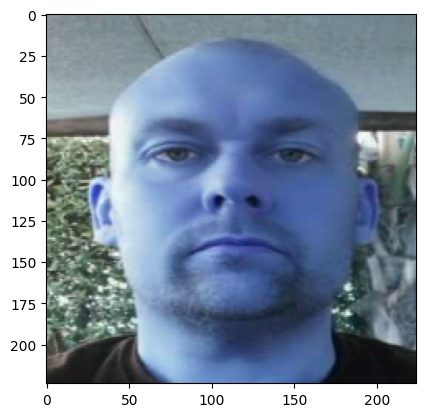

Actual BMI: 29.2105263158
Predicted BMI: 34.96220016479492


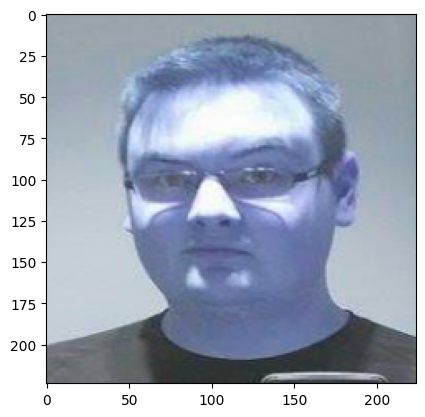

Actual BMI: 28.5504081633
Predicted BMI: 33.02230453491211


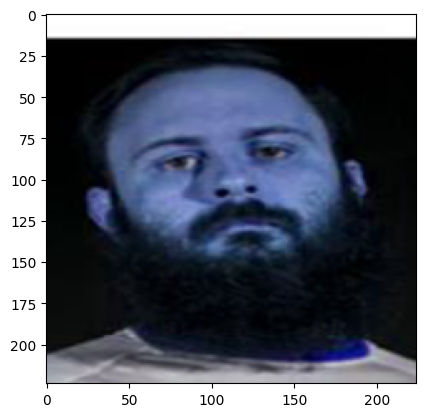

In [220]:
for i in [599,202,20,91,700]:
    print(f'Actual BMI: {y_test[i]}')
    print(f'Predicted BMI: {pred[i][0]}')
    plt.imshow(X_test_scaled[i])
    plt.show()